In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
from datetime import datetime
import pickle
import scipy.stats as st

from sklearn.metrics import mean_absolute_error as MAE
from sklearn import linear_model

import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import json
sys.path.insert(1, '../')
import lib.pe_down_loading_data_frame as loader
import lib.pe_utils as utils
import lib.pe_model as model
import lib.pe_config as conf
import lib.pe_df_analyzer as analyzer
import lib.pe_varmaker as va_m
import lib.pe_df_writer as writer
import lib.pe_metrics as metrics
import lib.pe_preprocessing as prepro


import lib.la_model as la_model

import imp

import json
sys.path.insert(1, '../')
import lib.pe_down_loading_data_frame as loader
imp.reload(loader)
import lib.pe_utils as utils
imp.reload(utils)
import lib.pe_model as model
imp.reload(model)
import lib.pe_config as conf
imp.reload(conf)
import lib.pe_df_analyzer as analyzer
imp.reload(analyzer)
import lib.pe_varmaker as va_m
imp.reload(va_m)
import lib.pe_df_writer as writer
imp.reload(writer)
import lib.pe_metrics as metrics
imp.reload(metrics)
import lib.pe_preprocessing as prepro
imp.reload(prepro)
import lib.la_prepro as la_prepro
imp.reload(la_prepro)
import lib.la_utils as la_utils
imp.reload(la_utils)
import lib.la_model as la_model
imp.reload(la_model)
load_model_data = utils.load_model_data
load_var_data  = utils.load_var_data
'''
import lib.pe_df_reader as reader
'''

'\nimport lib.pe_df_reader as reader\n'

In [2]:
dots = 5
two_week = 60 * 24 * 7 * 2
get_var = True
step = '1m'

start_date = '14/01/2020 00:01'
end_date = '18/05/2020 23:45'
folder = '14.01.2020_18.05.2020'

step = '1m'
dots=5
dc_period = {'au2-acs1': ['14/01/2020 00:01', '18/05/2020 23:45'],
             'eu3-acs1': ['14/01/2020 00:01', '18/05/2020 23:45'],
             'us3': ['14/01/2020 00:01', '18/05/2020 23:45'],
             'us6-acs2': ['14/01/2020 00:01', '18/05/2020 23:45']
            }

for dc in dc_period:
    for inst_num in conf.get_inst_range_for_dc(dc):
        start_time = dc_period[dc][0]
        end_time = dc_period[dc][1]
        
        load_model_data(dc, inst_num, start_time, end_time, dots)
        load_var_data(dc, inst_num, start_time, end_time, dots)


model:
DC=au2-acs1
INSTANCE=1
	data for model is already loaded

var:
DC=au2-acs1
INSTANCE=1
	var data already loaded

model:
DC=au2-acs1
INSTANCE=2
	data for model is already loaded

var:
DC=au2-acs1
INSTANCE=2
	var data already loaded

model:
DC=au2-acs1
INSTANCE=3
	data for model is already loaded

var:
DC=au2-acs1
INSTANCE=3
	var data already loaded

model:
DC=au2-acs1
INSTANCE=4
	data for model is already loaded

var:
DC=au2-acs1
INSTANCE=4
	var data already loaded

model:
DC=au2-acs1
INSTANCE=5
	data for model is already loaded

var:
DC=au2-acs1
INSTANCE=5
	var data already loaded

model:
DC=au2-acs1
INSTANCE=6
	data for model is already loaded

var:
DC=au2-acs1
INSTANCE=6
	var data already loaded

model:
DC=au2-acs1
INSTANCE=7
	data for model is already loaded

var:
DC=au2-acs1
INSTANCE=7
	var data already loaded

model:
DC=au2-acs1
INSTANCE=8
	data for model is already loaded

var:
DC=au2-acs1
INSTANCE=8
	var data already loaded

model:
DC=au2-acs1
INSTANCE=9
	data for model i

# Если хочешь взглянуть на уже обработанные данные, то просто загрузи 

## Loading results 

In [4]:
for_heat_map_duration = pd.read_csv('../datasets/'+folder+'/heat_map_duartion.csv', header = None, index_col = 0, names = list(range(1,32)))
for_heat_map_number = pd.read_csv('../datasets/'+folder+'/heat_map_nubmer.csv', header = None, index_col = 0, names = list(range(1,32)))
for_result = pd.read_csv('../datasets/'+folder+'/for_result.csv',index_col = 0 )

dc_reslut = json.load( open( "../datasets/"+folder+"/anomaly_and_sigma.json" ) )
dict_dc_inst_anomalies = json.load( open( "../datasets/"+folder+"/dict_dc_inst_anomalies.json" ) )
dict_dc_inst_anomalies_coeff = json.load( open( "../datasets/"+folder+"/dict_dc_inst_anomalies_coeff.json" ) )
anomalies_dict_for_dcs = json.load( open( "../datasets/"+folder+"/anomalies_dict_for_dcs.json" ) )
dict_dc_inst_metric = json.load( open( "../datasets/"+folder+"/dict_dc_inst_metric.json" ) )

# Иначе обработай новые данные) 

# Применим модель 

In [3]:
train_size = 60 * 24 * 7 
# dict_dc_inst_metric = {}
for dc in dc_period: 
    dict_dc = {}
    for inst_num in conf.get_inst_range_for_dc(dc):
        #coeff_df = pd.DataFrame()
        instance = utils.get_instance_for_dc(dc, inst_num)
        print(f'\nDC = {dc}\nINSTANCE = {instance}')
        start_time = dc_period[dc][0]
        end_time = dc_period[dc][1]
        
        st_time = start_time.replace(" ", "").replace("/", "").replace(":", "")
        en_time = end_time.replace(" ", "").replace("/", "").replace(":", "")
        
        out_file_name = 'for_plot/'
        out_file_name += utils.get_file_name(kind=f'simpleLR__train={train_size}__dots={dots}',
                                            dc=dc, inst_num=inst_num, st_time=st_time, en_time=en_time, 
                                            dots=dots)
        
#         out_file_name_for_fitted_model = 'for_fitted_model/'
#         out_file_name_for_fitted_model += utils.get_file_name(kind=f'simpleLR__train={train_size}__dots={dots}',
#                                             dc=dc, inst_num=inst_num, st_time=st_time, en_time=en_time, 
#                                             dots=dots)
        
        if not os.path.isfile(f'../datasets/{out_file_name}.csv'):
            # we already got fine model
            
            data_file_name = load_model_data(dc, inst_num, st_time, en_time, pri=False)

            # and data
            data = pd.read_csv(data_file_name)
            data = la_prepro.fill_misses(data)
            train_data = data[:train_size]
            print(f'train_data.shape={train_data.shape}')
            
            predictor = la_model.get_best_model()
            predictor.fit(train_data)  
#             model_name = '../datasets/' + out_file_name_for_fitted_model + '.sav'
#             pickle.dump(predictor, open(model_name, 'wb'))
            out = predictor.predict(data)
            out.dropna(inplace=True)
            
#             coeff_df['coef'] = predictor.est.coef_
#             coeff_df.index = predictor.features
#             min_v = 0
#             coeff_df = coeff_df[coeff_df['coef'] > min_v].sort_values('coef', ascending=False)
#             main_metrics = []
#             for metric in coeff_df.index.tolist():
#                 if not metric[-1] in [str(i) for i in list(range(1,10))]:
#                     main_metrics.append(metric)    
#                 else:
#                     if not metric[:-3] in main_metrics:
#                         main_metrics.append(metric[:-3])
#             if 'target' in main_metrics:
#                 main_metrics.remove('target')
#             if 'er' in main_metrics:
#                 main_metrics.remove('er')
#             main_metrics = main_metrics[:5]
#             dict_dc[inst_num] = main_metrics
            
            # for division by number of requests - 1 cell 
            #data['number_of_process'] = data[data.columns[1]].diff()
            
            out['predictions'] = predictor.scaler_y.inverse_transform(out['predictions_sc'].values.reshape(-1, 1))
            out['target_der'] = predictor.scaler_y.inverse_transform(out['target_der_sc'].values.reshape(-1, 1))
            
            y_hat = predictor.scaler_y.inverse_transform(out['predictions_sc'].values.reshape((-1, 1)))
            y = predictor.scaler_y.inverse_transform(out['target_der_sc'].values.reshape((-1, 1)))
            out['main_error'] = metrics.relative_mae(y, y_hat, abs_val=True, vectorize=True)
            
            # for division by number of requests - 2 cells
            #ts_out = set(out['time_stamp'].values.tolist())
            #out['main_error']= out['main_error']/data['number_of_process'][data['time_stamp'].isin(ts_out)]
            
            # for division by number of requests - 3 cells
            #out.dropna(inplace=True)
            #out.replace([np.inf, -np.inf], np.nan, inplace = True)
            #out.dropna(inplace=True)
            
            integrated = utils.get_inegral(init=out['target'].values[0], 
                                           values=out['predictions'].values)[1:]
            out['predicted_target'] = integrated
            # data with variance
            if get_var:
                bucket_query = 'abgw_iop_latency_ms_bucket{dc="' + dc + '"' + ', err="OK", iop="isync", instance="' 
                bucket_query += instance + '", proxied = "0"}'
                metric_start = 'abgw_req_latency_ms_bucket{le="'
                metirc_end = '", dc="' + dc +'", instance="' + instance +'", req="OpenFile+Append"} '
                var_file_name = load_var_data(dc, inst_num, st_time, en_time, pri=False)
                df_var = va_m.var_maker(start_time, end_time, bucket_query, metric_start, metirc_end,  data_path=var_file_name)
                out = pd.merge(out, df_var[['time_stamp', 'variance', 'mean']], how='outer', on='time_stamp')
            # ну а теперь пожалуй сохраним данные для отчётности
            writer.write_df(df=out, file_name=out_file_name)
        else:
            print('model was already applied for this dc and inst')
        # теперь обрабатываем и выявляем аномалии
#     dict_dc_inst_metric[dc] = dict_dc


DC = au2-acs1
INSTANCE = au2-acs1-stor01.vstoragedomain
model was already applied for this dc and inst

DC = au2-acs1
INSTANCE = au2-acs1-stor02.vstoragedomain
model was already applied for this dc and inst

DC = au2-acs1
INSTANCE = au2-acs1-stor03.vstoragedomain
model was already applied for this dc and inst

DC = au2-acs1
INSTANCE = au2-acs1-stor04.vstoragedomain
model was already applied for this dc and inst

DC = au2-acs1
INSTANCE = au2-acs1-stor05.vstoragedomain
model was already applied for this dc and inst

DC = au2-acs1
INSTANCE = au2-acs1-stor06.vstoragedomain
model was already applied for this dc and inst

DC = au2-acs1
INSTANCE = au2-acs1-stor07.vstoragedomain
model was already applied for this dc and inst

DC = au2-acs1
INSTANCE = au2-acs1-stor08.vstoragedomain
model was already applied for this dc and inst

DC = au2-acs1
INSTANCE = au2-acs1-stor09.vstoragedomain
model was already applied for this dc and inst

DC = au2-acs1
INSTANCE = au2-acs1-stor10.vstoragedomain
model w

In [76]:
# dict_dc_inst_metric = {}
# for dc in dc_period: 
#     dict_dc = {}
#     for inst_num in conf.get_inst_range_for_dc(dc):
#         coeff_df = pd.DataFrame()
#         instance = utils.get_instance_for_dc(dc, inst_num)
#         print(f'\nDC = {dc}\nINSTANCE = {instance}')
#         start_time = dc_period[dc][0]
#         end_time = dc_period[dc][1]
        
#         st_time = start_time.replace(" ", "").replace("/", "").replace(":", "")
#         en_time = end_time.replace(" ", "").replace("/", "").replace(":", "")
        
#         out_file_name = 'for_plot/'
#         out_file_name += utils.get_file_name(kind=f'simpleLR__train={train_size}__dots={dots}',
#                                             dc=dc, inst_num=inst_num, st_time=st_time, en_time=en_time, 
#                                             dots=dots)
        
            
#         data_file_name = load_model_data(dc, inst_num, st_time, en_time, dots, pri=False)

#         # and data
#         data = pd.read_csv(data_file_name)
#         data = la_prepro.fill_misses(data)
#         train_data = data[:train_size]
#         print(f'train_data.shape={train_data.shape}')

#         predictor = model.Model1_Scaled_Derive(dots=dots)
#         predictor.fit(train_data)   


#         coeff_df['coef'] = predictor.est.coef_
#         coeff_df.index = predictor.features
#         min_v = 0
#         coeff_df = coeff_df[coeff_df['coef'] > min_v].sort_values('coef', ascending=False)
#         main_metrics = []
#         for metric in coeff_df.index.tolist():
#             if not metric[-1] in [str(i) for i in list(range(1,10))]:
#                 main_metrics.append(metric)    
#             else:
#                 if not metric[:-3] in main_metrics:
#                     main_metrics.append(metric[:-3])
#         main_metrics.remove('target')
#         main_metrics = main_metrics[:5]
#         dict_dc[inst_num] = main_metrics
#     dict_dc_inst_metric[dc] = dict_dc

In [4]:
path = '../datasets/for_plot/'

norm_start_date = ''.join(''.join(''.join(start_date.split('/')).split(' ')).split(':'))
norm_end_date = ''.join(''.join(''.join(end_date.split('/')).split(' ')).split(':'))

dc_file = {}
for r, d, f in os.walk(path):
    for file in f:
        f_s = str(file).split('__')
        if f_s[0] == 'simpleLR' and f_s[2] == 'dots=5' and f_s[7] == '5.csv' and f_s[5] == norm_start_date and f_s[6] == norm_end_date :
            # if there is a novel dc
            if f_s[3] not in dc_file:
                dc_file[f_s[3]] = [file]
            # add a file name
            else:
                dc_file[f_s[3]].append(file)          

# Поиск сигм 

In [5]:
def find_number_of_sigmas(dcs):
    
    if type(dcs) == str:
        dcs = [dcs]
    
    path = '../datasets/for_plot/'
    month = 60 * 24 * 30
    
    dc_result = {}
    
    for dc in dcs:    
        print(f'DC {dc}')
        n_an = []
        n_main_error = []
        n_mean = []
        n_variance = []
        for n_s in np.linspace(4, 8.0, 41):
            print(f'\tn_s={n_s}')
            app = 0
            app_er = 0
            app_mean = 0 
            app_var = 0
            for file in sorted(dc_file[dc]):
                f_s = str(file).split('__')
                inst_n = int(f_s[4])
                dc = f_s[3]
                print(f'\t\tinst = {inst_n}')
                train_size = int(f_s[1][6:])
                duration = 0
                # getting data and adding a column with date
                plot_data = pd.read_csv(path + file).dropna()[train_size : train_size + 2*month]
                
                _reloads_ts = plot_data[plot_data['target'].diff() < 0]['time_stamp'].values
                plot_data = analyzer.get_df_with_droped_reloads(plot_data, _reloads_ts, reload_window=60 * 10)
                
                list_of_anomalys = analyzer.find_interval_of_anomaly_with_mode(plot_data, n_s,
                                                                         'and of mean and main_error')
                
                list_of_anomalys_main_error = analyzer.find_interval_of_anomaly_with_mode(plot_data, n_s,
                                                                         'main_error')
                
                list_of_anomalys_mean = analyzer.find_interval_of_anomaly_with_mode(plot_data, n_s,
                                                                         'mean')
                
                list_of_anomalys_var = analyzer.find_interval_of_anomaly_with_mode(plot_data, n_s,
                                                                         'variance')
                
#                 if list_of_anomalys:
#                     anomaly_duration = [(list_of_anomalys[i][1]-list_of_anomalys[i][0])/60 for i in range(len(list_of_anomalys))]
#                     list_of_anomalys = [list_of_anomalys[i] for i in range(len(list_of_anomalys)) if anomaly_duration[i] >= 3 ]
                
        
                app += len(list_of_anomalys)
                app_er += len(list_of_anomalys_main_error)
                app_mean += len(list_of_anomalys_mean)
                app_var += len(list_of_anomalys_var)
                    
            n_an.append(app)
            n_main_error.append(app_er)
            n_mean.append(app_mean)
            n_variance.append(app_var)
            number_of_sigmas = n_s
            # 14/30 так как мы ожидаем за 30 дней на полностью загруденном сервере 25 аномалий, а тут 2 недели
            if  app <= np.round(len(dc_file[dc])*(20/30)*2):
                number_of_sigmas = n_s
                break
                
        dc_result[dc] = [number_of_sigmas, n_an,n_main_error, n_mean, n_variance]
    return dc_result

In [6]:
dcs = list(dc_file.keys())
dc_reslut = find_number_of_sigmas(dcs)

DC us3
	n_s=4.0
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 2
		inst = 3
		inst = 4
		inst = 5
		inst = 7
		inst = 8
		inst = 9
	n_s=4.1
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 2
		inst = 3
		inst = 4
		inst = 5
		inst = 7
		inst = 8
		inst = 9
	n_s=4.2
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 2
		inst = 3
		inst = 4
		inst = 5
		inst = 7
		inst = 8
		inst = 9
	n_s=4.3
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 2
		inst = 3
		inst = 4
		inst = 5
		inst = 7
		inst = 8
		inst = 9
	n_s=4.4
		inst = 10
		inst =

		inst = 5
		inst = 7
		inst = 8
		inst = 9
	n_s=7.4
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 2
		inst = 3
		inst = 4
		inst = 5
		inst = 7
		inst = 8
		inst = 9
	n_s=7.5
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 2
		inst = 3
		inst = 4
		inst = 5
		inst = 7
		inst = 8
		inst = 9
	n_s=7.6
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 2
		inst = 3
		inst = 4
		inst = 5
		inst = 7
		inst = 8
		inst = 9
	n_s=7.7
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 2
		inst = 3
		inst = 4
		inst = 5
		inst = 7
		inst = 8
		i

		inst = 7
		inst = 8
		inst = 9
	n_s=4.2
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 22
		inst = 23
		inst = 24
		inst = 25
		inst = 26
		inst = 27
		inst = 28
		inst = 29
		inst = 2
		inst = 30
		inst = 31
		inst = 3
		inst = 4
		inst = 5
		inst = 6
		inst = 7
		inst = 8
		inst = 9
	n_s=4.3
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 22
		inst = 23
		inst = 24
		inst = 25
		inst = 26
		inst = 27
		inst = 28
		inst = 29
		inst = 2
		inst = 30
		inst = 31
		inst = 3
		inst = 4
		inst = 5
		inst = 6
		inst = 7
		inst = 8
		inst = 9
	n_s=4.4
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 22
		inst = 23
		inst = 24
		inst = 25
		inst = 26

		inst = 7
		inst = 8
		inst = 9
	n_s=6.4
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 22
		inst = 23
		inst = 24
		inst = 25
		inst = 26
		inst = 27
		inst = 28
		inst = 29
		inst = 2
		inst = 30
		inst = 31
		inst = 3
		inst = 4
		inst = 5
		inst = 6
		inst = 7
		inst = 8
		inst = 9
	n_s=6.5
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 22
		inst = 23
		inst = 24
		inst = 25
		inst = 26
		inst = 27
		inst = 28
		inst = 29
		inst = 2
		inst = 30
		inst = 31
		inst = 3
		inst = 4
		inst = 5
		inst = 6
		inst = 7
		inst = 8
		inst = 9
	n_s=6.6
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 22
		inst = 23
		inst = 24
		inst = 25
		inst = 26

		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 22
		inst = 23
		inst = 24
		inst = 25
		inst = 26
		inst = 27
		inst = 28
		inst = 29
		inst = 2
		inst = 30
		inst = 3
		inst = 4
		inst = 5
		inst = 6
		inst = 7
		inst = 8
		inst = 9
	n_s=5.0
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 22
		inst = 23
		inst = 24
		inst = 25
		inst = 26
		inst = 27
		inst = 28
		inst = 29
		inst = 2
		inst = 30
		inst = 3
		inst = 4
		inst = 5
		inst = 6
		inst = 7
		inst = 8
		inst = 9
	n_s=5.1
		inst = 10
		inst = 11
		inst = 12
		inst = 13
		inst = 14
		inst = 15
		inst = 16
		inst = 17
		inst = 18
		inst = 19
		inst = 1
		inst = 20
		inst = 21
		inst = 22
		inst = 23
		inst = 24
		inst = 25
		inst = 26
		inst = 27
		inst = 28
		inst = 29
		inst = 2
		inst = 30
		inst = 3
		inst = 4
		inst = 5
		inst = 

In [9]:
def plot_sigmas_anomalies(dc_result):
    for dc in dc_result:
        fig = make_subplots(rows = 1, cols=1)
        number_of_sigmas = dc_result[dc][0]
        n_an = dc_result[dc][1]
        n_main_error = dc_result[dc][2]
        n_mean = dc_result[dc][3]
        n_variance = dc_result[dc][4]
        x = np.linspace(4.0, 8.0, 41)[:len(n_an)]
        fig.add_trace(go.Scatter(x=x, y=n_an, name = 'main error and mean'), row = 1 , col = 1)
        fig.add_trace(go.Scatter(x=x, y=n_main_error, name = 'main error ', marker_color = 'blue'), row = 1 , col = 1 )
        fig.add_trace(go.Scatter(x=x, y=n_mean, name = 'mean', marker_color = 'green'), row = 1 , col = 1 )
        fig.add_trace(go.Scatter(x=x, y=n_variance, name = 'variance', marker_color = 'gold'), row = 1 , col = 1 )
        fig.update_layout(height=500, width=700, title_text = 'dc = ' + dc, xaxis_title="Number of sigmas",
        yaxis_title="Number of anomalies")
        fig.show()

In [10]:
plot_sigmas_anomalies(dc_reslut)

# Подведём какие-то итоги 

In [94]:
dcs = list(dc_file.keys())
dc_reslut = {'us3' : [6.0], 'au2-acs1' : [6.0],'eu3-acs1' : [6.0],'us6-acs2' : [5.7]}

In [11]:
def results(dcs, dc_result):
    month = 60*24*30
    path = '../datasets/for_plot/'
    html_path = '../datasets/plots/'
    
    for_heat_map_duration = pd.DataFrame(np.zeros((4, 31)),index = dcs,
                                         columns = [i for i in range(1,32)])

    for_heat_map_number = pd.DataFrame(np.zeros((4, 31)),
                                   index = dcs,
                                   columns = [i for i in range(1,32)]
                                  )

    for_result = pd.DataFrame(index = dcs,
                          columns = ['Number of sigmas',
                                     'Number of anomalies',
                                     'Expected number of anomalies',
                                     'Amount of anomaly-time']
                         )
    dict_dc_inst_anomalies = {}
    dict_dc_inst_anomalies_coeff = {}
    anomalies_dict_for_dcs = {}
    
    for dc in dc_result:
        dict_dc = {}
        dict_dc_coeff = {}
        anomalies_dict_for_dc = {}
        number_of_all_anomalies = 0
        n_s = dc_reslut[dc][0]
        inst_and_duration_anomalies = {}
        inst_and_number_anomalies = {}
        all_duration = 0
        
        for file in sorted(dc_file[dc]):
            duration = 0
            f_s = str(file).split('__')
            inst_n = int(f_s[4])
            dc = f_s[3]
            
            # getting data and adding a column with date
            train_size = int(f_s[1][6:])
            plot_data = pd.read_csv(path + file).dropna()[train_size + month:]
            reloads_ts = plot_data[plot_data['target_der'] < 0]['time_stamp'].values
            plot_data = analyzer.get_df_with_no_reloads(plot_data, reloads_ts, 'predicted_target')
            plot_data = analyzer.get_df_with_no_reloads(plot_data, reloads_ts, 'target')  
            plot_data = analyzer.get_df_with_droped_reloads(plot_data, reloads_ts, reload_window=60 * 10)
            
            list_of_anomalys = analyzer.find_interval_of_anomaly_with_mode(plot_data, n_s,
                                                                           'and of mean and main_error')
            
            anomalies_dict_for_dc[inst_n] = list_of_anomalys
        
            if list_of_anomalys:
                anomaly_duration = [(list_of_anomalys[i][1]-list_of_anomalys[i][0])/60 for i in range(len(list_of_anomalys))]
                list_of_anomalys = [list_of_anomalys[i] for i in range(len(list_of_anomalys)) if anomaly_duration[i] >= 3 ]
                if list_of_anomalys:
                    anomaly_duration = [(list_of_anomalys[i][1]-list_of_anomalys[i][0])/60 for i in range(len(list_of_anomalys))]
                    dict_dc[inst_n] = list_of_anomalys
                    print(f'dc = {dc}')
                    print(f'inst_n = {inst_n}; anomalies: {list_of_anomalys}')
                    both_coeff = []
                    for mode in ['mean', 'main_error']:
                        s, mu = analyzer.get_var_and_mean(plot_data, mode)
                        an_point = analyzer.get_anomaly_dots(plot_data, s, mu, n_s, mode)
                        number_of_point_in_inerval = [len([j for j in an_point if (j >= list_of_anomalys[i][0] and j <= list_of_anomalys[i][1])]) for i in range(len(list_of_anomalys))]
                        coef = [number_of_point_in_inerval[i]/(anomaly_duration[i]+1) for i in range(len(anomaly_duration))]
                        both_coeff.append(coef)
                    final_coeff = list((np.array(both_coeff[0]) + np.array(both_coeff[1]))/2)
                    final_coeff = [np.round(final_coeff[i], decimals = 2) for i in range(len(final_coeff))]
                    dict_dc_coeff[inst_n] = final_coeff
        
                
    
            number_of_all_anomalies += len(list_of_anomalys)
            
            if list_of_anomalys:
                for anomaly in list_of_anomalys:
                    duration += (anomaly[1]-anomaly[0])
                    inst_and_duration_anomalies[inst_n] = duration
            else:
                inst_and_duration_anomalies[inst_n] = 0
                    
                    
            if list_of_anomalys:
                inst_and_number_anomalies[inst_n] = len(list_of_anomalys)
            else:
                inst_and_number_anomalies[inst_n] = 0
                
                
        for i in inst_and_duration_anomalies:
                    inst_and_duration_anomalies[i] = inst_and_duration_anomalies[i]//60
                
        for duration in inst_and_duration_anomalies:
                all_duration += inst_and_duration_anomalies[duration]
            
        
        for_heat_map_duration.loc[dc] = inst_and_duration_anomalies
        for_heat_map_number.loc[dc] = inst_and_number_anomalies
        for_result.loc[dc] = {'Number of sigmas': n_s,
                             'Number of anomalies': number_of_all_anomalies,
                              'Expected number of anomalies': np.round(len(dc_file[dc])*(20/30)*(plot_data.shape[0]/(60*24*30))), 
                             'Amount of anomaly-time': all_duration }
        dict_dc_inst_anomalies[dc] = dict_dc
        dict_dc_inst_anomalies_coeff[dc] = dict_dc_coeff
        anomalies_dict_for_dcs[dc] = anomalies_dict_for_dc
    return [for_heat_map_duration,for_heat_map_number,for_result,dict_dc_inst_anomalies,dict_dc_inst_anomalies_coeff, anomalies_dict_for_dcs]

In [12]:
for_heat_map_duration, for_heat_map_number, for_result, dict_dc_inst_anomalies, dict_dc_inst_anomalies_coeff, anomalies_dict_for_dcs = results(dcs, dc_reslut)

dc = us3
inst_n = 12; anomalies: [[1586334120, 1586335920]]
dc = us3
inst_n = 13; anomalies: [[1586333160, 1586335260], [1586736720, 1586737680]]
dc = us3
inst_n = 14; anomalies: [[1586335620, 1586336160]]
dc = us3
inst_n = 15; anomalies: [[1586330460, 1586332020]]
dc = us3
inst_n = 16; anomalies: [[1588190940, 1588193340], [1589404140, 1589405580]]
dc = us3
inst_n = 18; anomalies: [[1586330460, 1586336460], [1586733060, 1586734020]]
dc = us3
inst_n = 19; anomalies: [[1586330460, 1586333160], [1586407560, 1586408760], [1586580060, 1586580540], [1586664120, 1586664720], [1586732940, 1586737740], [1586767140, 1586768520]]
dc = us3
inst_n = 1; anomalies: [[1586330940, 1586335920]]
dc = us3
inst_n = 20; anomalies: [[1586329920, 1586330700], [1586706060, 1586706240], [1586732880, 1586736540], [1586771820, 1586773260]]
dc = us3
inst_n = 2; anomalies: [[1586331360, 1586333820], [1586335620, 1586336640]]
dc = us3
inst_n = 3; anomalies: [[1586331540, 1586335740], [1586740320, 1586740860]]
dc = 

## Saving results 

In [76]:
for_heat_map_duration.to_csv('../datasets/'+folder+'/heat_map_duartion.csv', header=False)
for_heat_map_number.to_csv('../datasets/'+folder+'/heat_map_nubmer.csv', header=False) 
for_result.to_csv('../datasets/'+folder+'/for_result.csv') 

json.dump(dc_reslut, open( "../datasets/"+folder+"/anomaly_and_sigma.json", 'w' ) )
json.dump(dict_dc_inst_anomalies, open( "../datasets/"+folder+"/dict_dc_inst_anomalies.json", 'w' ))
json.dump(dict_dc_inst_anomalies_coeff, open( "../datasets/"+folder+"/dict_dc_inst_anomalies_coeff.json", 'w'))
json.dump(anomalies_dict_for_dcs, open( "../datasets/"+folder+"/anomalies_dict_for_dcs.json", 'w'))
#json.dump(dict_dc_inst_metric, open( "../datasets/"+folder+"/dict_dc_inst_metric.json", 'w'))

Text(0.5, 1.0, 'Number of anomalies')

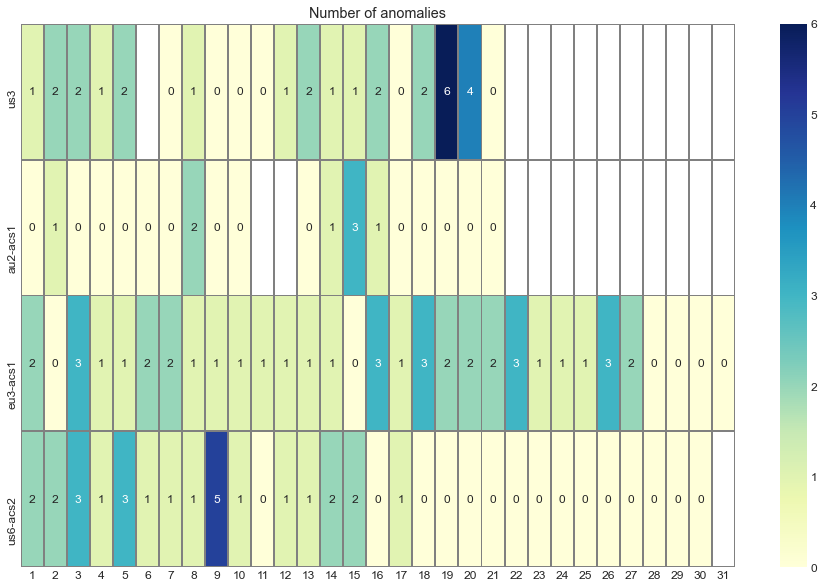

In [13]:
plt.figure(figsize=(16, 10))  
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12})
sns.heatmap(for_heat_map_number, cmap="YlGnBu", linewidths=1 ,annot=True, linecolor = 'gray',  fmt = "g").set_title('Number of anomalies')

Text(0.5, 1.0, 'Duration of anomalies')

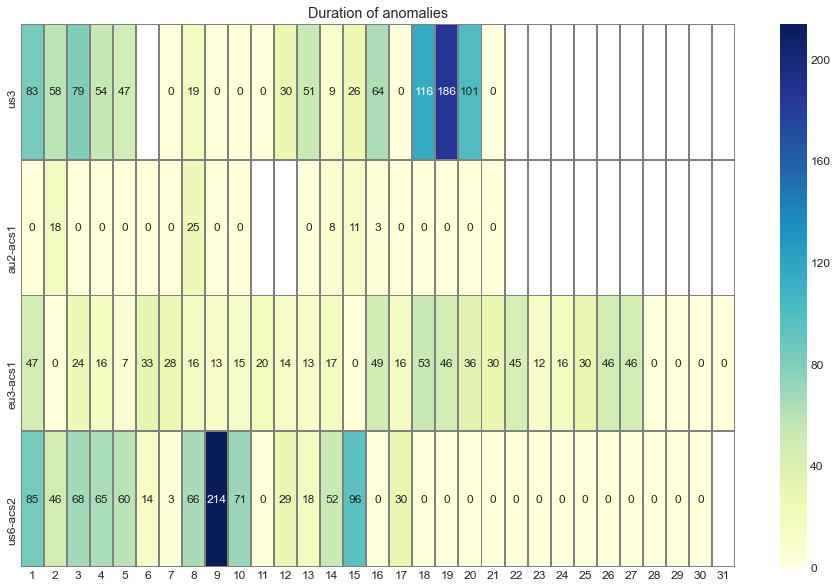

In [14]:
fig, ax = plt.subplots(figsize=(16,10))
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12})
sns.heatmap(for_heat_map_duration, cmap="YlGnBu", linewidths=1 ,annot=True, linecolor = 'gray', ax = ax, fmt = 'g').set_title('Duration of anomalies')

In [15]:
for_result

,Number of sigmas,Number of anomalies,Expected number of anomalies,Amount of anomaly-time
us3,8,28,20,923
au2-acs1,6.4,8,21,65
eu3-acs1,7.6,42,35,688
us6-acs2,5.7,27,29,917


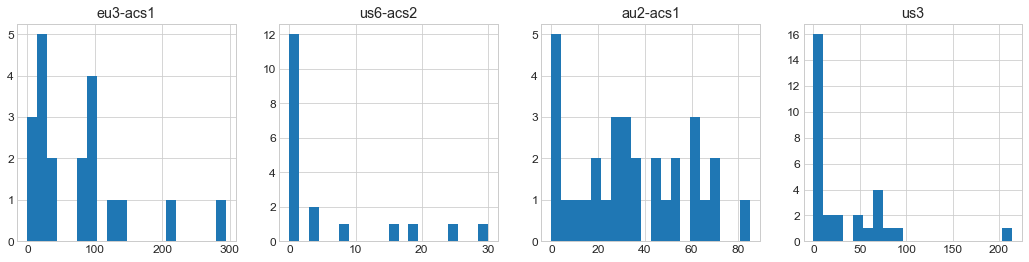

In [15]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (18.0, 4.0)
plt.subplot(141)
plt.hist(for_heat_map_duration.iloc[0], bins =20)
plt.title('eu3-acs1') 
plt.subplot(142)
plt.hist(for_heat_map_duration.iloc[1], bins =20)
plt.title('us6-acs2') 
plt.subplot(143)
plt.hist(for_heat_map_duration.iloc[2].dropna(), bins =20)
plt.title('au2-acs1') 
plt.subplot(144)
plt.hist(for_heat_map_duration.iloc[3].dropna(), bins =20)
plt.title('us3') 
plt.show()

In [18]:
def percentile_maker(start_time, finis_time, query_bucket, metric_start, metric_end,anomaly,  step='1m', data_path=None, for_anomaly = True):
    
    if data_path is None:
        df = loader.get_normalized_time_series(query=query_bucket,
                                               finish=finis_time,
                                               start=start_time,
                                               step=step
                                               )
    else:
        df = pd.read_csv(data_path)
        
    df = utils.get_df_with_renamed_col_for_var(df)
    df1 = pd.DataFrame.copy(df)
    df = df[df.columns[2:]]
    df = df.diff()
    df['summ'] = df[metric_start + '+Inf' + metric_end]
    
    list_of_reloads_indexes = df[df['summ'] < 0].index.tolist()
    list_of_previous_indexes = [i - 1 for i in list_of_reloads_indexes]
    df.iloc[list_of_reloads_indexes] += df1.iloc[list_of_previous_indexes]
    
    list_of_reloads_indexes = df[df[df.columns[0]] < 0].index.tolist()
    list_of_previous_indexes = [i - 1 for i in list_of_reloads_indexes]
    df.iloc[list_of_reloads_indexes] += df1.iloc[list_of_previous_indexes]
    
    df['target'] = df1['target']
    df['time_stamp'] = df1['time_stamp']
    df = df.drop(df.index[0])
    df = df.drop(columns = [metric_start + '+Inf' + metric_end])
    df.dropna(inplace = True)
    if for_anomaly:
        df = df[df['time_stamp'].isin([anomaly[0] - shift * 60 for shift in range(60*24)]+
                                             [anomaly[1] + shift * 60 for shift in range(1,60*24)])]

    numbers_1 = conf.get_var_numbers_1()
    df['99th_percentile'] = df[df.columns[:33]].apply(lambda row: sum(1-(row//(row['summ']*0.99))) ,axis = 1)
    df.dropna(inplace = True)
    df['99th_percentile'] = df['99th_percentile'].apply(lambda x: numbers_1[int(x)-1] if int(x) > 0 else numbers_1[0])
    return df

# Персентили для аномальных данных 

In [15]:
for dc in dict_dc_inst_anomalies: # dc_period:
    for inst_num in list(dict_dc_inst_anomalies[dc].keys()):
        instance = utils.get_instance_for_dc(dc, int(inst_num))
        print(f'\nDC={dc}\nINSTANCE={instance}')
        start_time = dc_period[dc][0]
        end_time = dc_period[dc][1]
        
        st_time = start_time.replace(" ", "").replace("/", "").replace(":", "")
        en_time = end_time.replace(" ", "").replace("/", "").replace(":", "")
    
        bucket_query = 'abgw_iop_latency_ms_bucket{dc="' + dc + '"' + ', err="OK", iop="isync", instance="' 
        bucket_query += instance + '", proxied = "0"}'
        metric_start = 'abgw_req_latency_ms_bucket{le="'
        metirc_end = '", dc="' + dc +'", instance="' + instance +'", req="OpenFile+Append"} '

        var_file_name = load_var_data(dc, inst_num, st_time, en_time, pri=False)
        for anomaly in dict_dc_inst_anomalies[dc][inst_num]:
            print(anomaly)
            out_file_name = 'percentile/'
            out_file_name += utils.get_file_name(kind='percentile',
                                            dc=dc, inst_num=inst_num, st_time=anomaly[0], en_time=anomaly[1])
            df_per = percentile_maker(start_time, end_time, bucket_query, metric_start, metirc_end, anomaly, data_path=var_file_name, for_anomaly = False)
            writer.write_df(df=df_per, file_name=out_file_name)


DC=au2-acs1
INSTANCE=au2-acs1-stor14.vstoragedomain
[1586516580, 1586517060]

DC=au2-acs1
INSTANCE=au2-acs1-stor15.vstoragedomain
[1585748760, 1585749060]
[1586612160, 1586612340]
[1586860740, 1586860980]
[1589199240, 1589199360]
[1589472960, 1589473140]

DC=au2-acs1
INSTANCE=au2-acs1-stor16.vstoragedomain
[1586516880, 1586517060]

DC=au2-acs1
INSTANCE=au2-acs1-stor02.vstoragedomain
[1588606920, 1588608000]

DC=au2-acs1
INSTANCE=au2-acs1-stor03.vstoragedomain
[1585748760, 1585748940]
[1586784780, 1586786400]

DC=au2-acs1
INSTANCE=au2-acs1-stor04.vstoragedomain
[1588341360, 1588341540]
[1589129040, 1589129160]

DC=au2-acs1
INSTANCE=au2-acs1-stor08.vstoragedomain
[1585624860, 1585625220]
[1588606920, 1588608060]

DC=eu3-acs1
INSTANCE=eu3-acs1-stor10.vstoragedomain
[1585573260, 1585573380]
[1585721940, 1585723740]
[1585814820, 1585816500]
[1585823160, 1585823940]
[1587463380, 1587464340]

DC=eu3-acs1
INSTANCE=eu3-acs1-stor11.vstoragedomain
[1585815840, 1585817400]
[1587463440, 1587464640

# Пенсентили для всех данных 

In [22]:
for dc in dict_dc_inst_anomalies: # dc_period:
    for inst_num in list(dict_dc_inst_anomalies[dc].keys()): 
        instance = utils.get_instance_for_dc(dc, int(inst_num))
        print(f'\nDC={dc}\nINSTANCE={instance}')
        start_time = dc_period[dc][0]
        end_time = dc_period[dc][1]
        
        st_time = start_time.replace(" ", "").replace("/", "").replace(":", "")
        en_time = end_time.replace(" ", "").replace("/", "").replace(":", "")
    
        bucket_query = 'abgw_iop_latency_ms_bucket{dc="' + dc + '"' + ', err="OK", iop="isync", instance="' 
        bucket_query += instance + '", proxied = "0"}'
        metric_start = 'abgw_req_latency_ms_bucket{le="'
        metirc_end = '", dc="' + dc +'", instance="' + instance +'", req="OpenFile+Append"} '

        var_file_name = load_var_data(dc, inst_num, st_time, en_time, pri=False)

        out_file_name = 'percentile/'
        out_file_name += utils.get_file_name(kind='percentile',
                                        dc=dc, inst_num=inst_num, st_time = 0 , en_time = 1)
        if not os.path.isfile(f'../datasets/{out_file_name}.csv'):
            df_per = percentile_maker(start_time, end_time, bucket_query, metric_start, metirc_end, anomaly, data_path=var_file_name, for_anomaly = False)
            writer.write_df(df=df_per, file_name=out_file_name)


DC=us3
INSTANCE=us3-acs1-stor10.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor11.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor12.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor13.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor14.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor15.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor16.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor18.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor19.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor01.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor20.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor02.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor03.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor04.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor05.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor08.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor09.vstoragedomain

DC=au2-acs1
INSTANCE=au2-acs1-stor14.vstoragedomain

DC=au2-acs1
INSTANCE=au2-acs1-stor15.vstoragedomain

DC=au2-acs1
INSTANCE=au2-acs1-stor16.vstoragedomain

DC=au2-acs1
INSTANCE=au2

In [92]:
def get_plotly_wiht_sep_an(df, columns, list_of_anomalys, dc, inst_num, reloads, perc_df, mean_an=[], err_an=[]):
    if 'target_der' not in df.columns.values:
        print('hmmmm it seems you are to get new ../datasets/for_plot/...')
        print('the suitable version established on 03.03.2020')
    colors = ['purple', 'pink', 'green', 'blue', 'yellow', 'blue', 'aquamarine', 'black']
    fig = make_subplots(rows=5, cols=1)
    number_of_picture_in_subplot = 3
    for column, color in zip(columns, colors):
        spec_group = False

        if column in ['target_der_sc', 'predictions_sc']:
            fig.add_trace(go.Scatter(
                x=df['date'],
                y=df[column],
                line_color=color,
                name=column,
                opacity=0.8), row=1, col=1)
            for rl in reloads:
                fig.add_trace(go.Scatter(
                    x=[datetime.fromtimestamp(rl), datetime.fromtimestamp(rl)],
                    y=[0, max(df['target_der_sc'])],
                    line_color='black',
                    name='reload',
                    opacity=0.8), row=1, col=1)
            spec_group = True
            
        if column in ['99th_percentile']:
            fig.add_trace(go.Scatter(
                x=perc_df['date'][perc_df['time_stamp']>df['time_stamp'].min()],
                y=perc_df[column][perc_df['time_stamp']>df['time_stamp'].min()],
                line_color=color,
                name=column,
                opacity=0.8), row=2, col=1)
            spec_group = True
            

        if column in ['target', 'predicted_target']:
#             fig.add_trace(go.Scatter(
#                 x=df['date'],
#                 y=df[column],
#                 line_color=color,
#                 name=column,
#                 opacity=0.8), row=3, col=1)
            spec_group = True

        if not spec_group:
            fig.add_trace(go.Scatter(
                x=df['date'],
                y=df[column],
                line_color=color,
                name=column,
                opacity=0.8), row=number_of_picture_in_subplot, col=1)
            number_of_picture_in_subplot += 1
    plot_anomaly(df, list_of_anomalys, fig, row=1)
    plot_anomaly(df, err_an, fig, column='main_error', kind_of_anomaly='error anomaly', row=3)
    plot_anomaly(df, mean_an, fig, column='mean', kind_of_anomaly='mean_latency_anomaly', row=4)
    fig.update_layout(height=280*5, width=900, title_text='dc = ' + dc + ' inst_num = ' + str(inst_num))
    # plotly.offline.plot(fig,filename='sampleplot.html')
    return fig


def plot_anomaly(df, list_of_anomaly, fig, column='target_der_sc', kind_of_anomaly='anomaly', row=1):
    i = 0
    for anomaly in list_of_anomaly:
        if i == 0:
            fig.add_trace(go.Scatter(
                x=df['date'].loc[
                  list(df[df['time_stamp'] == anomaly[0]].index)[0]:list(df[df['time_stamp'] == anomaly[1]].index)[0]],
                y=df[column].loc[
                  list(df[df['time_stamp'] == anomaly[0]].index)[0]:list(df[df['time_stamp'] == anomaly[1]].index)[0]],
                line_color='red',
                line_width=3,
                name=kind_of_anomaly,
                opacity=0.9), row=row, col=1)
            i += 1
        else:
            fig.add_trace(go.Scatter(
                x=df['date'].loc[
                  list(df[df['time_stamp'] == anomaly[0]].index)[0]:list(df[df['time_stamp'] == anomaly[1]].index)[0]],
                y=df[column].loc[
                  list(df[df['time_stamp'] == anomaly[0]].index)[0]:list(df[df['time_stamp'] == anomaly[1]].index)[0]],
                line_color='red',
                line_width=3,
                showlegend=False,
                opacity=0.9), row=row, col=1)



In [39]:
# path = '../datasets/for_plot_div_by_error/'
# html_path = '../datasets/plots_div_by_error/'
# n_an = []
# for dc in ['au2-acs1']:
#     for file in sorted(dc_file[dc]):
#         print(file)
#         f_s = str(file).split('__')
#         print(f'DC={f_s[3]}\nINST_N={f_s[4]}\n{f_s[2]}\n{f_s[1]}')
#         inst_n = int(f_s[4])
#         dc = f_s[3]
#         # getting data and adding a column with date
#         train_size = int(f_s[1][6:])
#         plot_data = pd.read_csv(path + file).dropna()[train_size + two_week:]
#         reloads_ts = plot_data[plot_data['target_der'] < 0]['time_stamp'].values
#         print(f'reloads time_stamps: {reloads_ts}')
#         # then fit bound before and after reloads
#         plot_data = analyzer.get_df_with_no_reloads(plot_data, reloads_ts, 'predicted_target')
#         plot_data = analyzer.get_df_with_no_reloads(plot_data, reloads_ts, 'target')
#         plot_data = analyzer.get_df_with_droped_reloads(plot_data, reloads_ts, reload_window=60 * 10)

#         plot_data['date'] = plot_data['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))
#         # anomaly stuff
        
        
        
#         error_anomalys = analyzer.find_interval_of_anomaly_with_simple_mode(plot_data, n_s[dc], 
#                                                                             'main_error')
#         mean_anomalys = analyzer.find_interval_of_anomaly_with_simple_mode(plot_data, n_s[dc], 'mean')
#         list_of_anomalys = analyzer.intersection_of_two_lists_of_anomalies(error_anomalys,
#                                                                            mean_anomalys)
#         print(list_of_anomalys)

#         n_an.append(len(list_of_anomalys))
#         # an statistic for anomaly
#         an_len = 0
#         for interval in list_of_anomalys:
#             an_len += interval[1] - interval[0]
#         total_time = max(plot_data['time_stamp'].values) - min(plot_data['time_stamp'].values)
#         print(f'a part of animaly time is {an_len/total_time * 100}%\n')
#         # plotting, RAM-consuming
#         # '''
#         fig = get_plotly_wiht_sep_an(plot_data, ['target_der_sc', 'predictions_sc','main_error', 
#                                               'mean', 'variance', 'predicted_target', 'target'],
#                                   list_of_anomalys, dc, inst_n, reloads_ts, mean_an=mean_anomalys,
#                                   err_an=error_anomalys)
#         plot(fig, filename=f'{html_path}{file}.html', auto_open=False)

#         #and plot there matplotlib plots
#         '''
#         fig, axs = pe_plt.get_ez_ram_plt(plot_data, list_of_anomalys, reloads_ts)
#         plt.show()
#         '''

# Графики в оригинальных и наших переменных 

In [97]:
path = '../datasets/for_plot/'
html_path = '../datasets/plots/'
month = 60 * 24 * 30
n_s = for_result['Number of sigmas'].to_dict()
for dc in ['eu3-acs1']:#dict_dc_inst_anomalies: 
    for inst_num in [2]:#list(dict_dc_inst_anomalies[dc].keys()):
        instance = utils.get_instance_for_dc(dc, int(inst_num))
        print(f'\nDC = {dc}\nINSTANCE = {instance}')
#         start_time = dc_period[dc][0]
#         end_time = dc_period[dc][1]
        
#         st_time = start_time.replace(" ", "").replace("/", "").replace(":", "")
#         en_time = end_time.replace(" ", "").replace("/", "").replace(":", "")

        
#         data_file_name = load_model_data(dc, inst_num, st_time, en_time, pri=False)
#         data = pd.read_csv(data_file_name)
#         data['date'] = data['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))
        
        file = [inst for inst in sorted(dc_file[dc]) if int(inst_num) == int(str(inst).split('__')[4])][0]
        f_s = str(file).split('__')
        train_size = int(f_s[1][6:])
        plot_data = pd.read_csv(path + file).dropna()[train_size + month:]
        reloads_ts = plot_data[plot_data['target_der'] < 0]['time_stamp'].values
        # then fit bound before and after reloads
        plot_data = analyzer.get_df_with_no_reloads(plot_data, reloads_ts, 'predicted_target')
        plot_data = analyzer.get_df_with_no_reloads(plot_data, reloads_ts, 'target')
        plot_data = analyzer.get_df_with_droped_reloads(plot_data, reloads_ts, reload_window=60 * 10)

        plot_data['date'] = plot_data['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))
        # anomaly stuff
        
        error_anomalys = analyzer.find_interval_of_anomaly_with_simple_mode(plot_data, n_s[dc], 
                                                                            'main_error')
        mean_anomalys = analyzer.find_interval_of_anomaly_with_simple_mode(plot_data, n_s[dc], 'mean')
        list_of_anomalys = analyzer.intersection_of_two_lists_of_anomalies(error_anomalys,
                                                                           mean_anomalys)
        
        
        
            
        perc_name = '../datasets/percentile/'
        perc_name += utils.get_file_name(kind='percentile',
                                        dc=dc, inst_num=inst_num, st_time=0, en_time=1)
        perc_name += '.csv'
        perc_data = pd.read_csv(perc_name)
        perc_data['date'] = perc_data['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))
        
        fig = get_plotly_wiht_sep_an(plot_data, ['target_der_sc', 'predictions_sc','99th_percentile','main_error', 
                                              'mean', 'variance', 'predicted_target', 'target'],
                                  list_of_anomalys, dc, inst_num, reloads_ts, perc_data, mean_an=mean_anomalys,
                                  err_an=error_anomalys)
            
           
        plot(fig, filename=f'{html_path}dc={dc}__inst_n={inst_num}__4mnth.html', auto_open=False)
        
    
#             ts_intervals = [j for j in data['time_stamp'].values.tolist() if (j >= anomaly[0] - 60*10 and j <= anomaly[1] + 60*10)]
#             an_intervals = [j for j in data['time_stamp'].values.tolist() if (j >= anomaly[0]  and j <= anomaly[1] )]
#             fig = make_subplots(rows = 5 , cols=1)
#             colors = ['purple', 'pink', 'green', 'gold', 'yellow', 'blue']
#             for i, metric in enumerate(dict_dc_inst_metric[dc][inst_num]):
#                 if not metric == "er":
#                     fig.add_trace(go.Scatter(x=data['date'][train_size + two_week:], y=data[metric][train_size + two_week:].diff(), name = metric[4:], marker_color = colors[i]), row = i + 1 , col = 1)
#                     fig.add_trace(go.Scatter(x=data.loc[data['time_stamp'].isin(an_intervals)]['date'], y=data.loc[data['time_stamp'].isin(an_intervals)][metric].diff(), marker_color='red', showlegend=False,), row = i + 1 , col = 1)
#             fig.update_layout(height=1200, width=900, title_text = 'dc = ' + dc + ' inst_n = '+ str(inst_num)+ ' coeff = ' + str(dict_dc_inst_anomalies_coeff[dc][inst_num][j]) , xaxis_title = "Date")
#             fig.show()


DC = eu3-acs1
INSTANCE = eu3-acs1-stor02.vstoragedomain


In [20]:
path = '../datasets/for_plot/'
html_path = '../datasets/plots/'
month = 60 * 24 * 30
n_s = for_result['Number of sigmas'].to_dict()
for dc in dict_dc_inst_anomalies: 
    for inst_num in list(dict_dc_inst_anomalies[dc].keys()):
        instance = utils.get_instance_for_dc(dc, int(inst_num))
        print(f'\nDC = {dc}\nINSTANCE = {instance}')
#         start_time = dc_period[dc][0]
#         end_time = dc_period[dc][1]
        
#         st_time = start_time.replace(" ", "").replace("/", "").replace(":", "")
#         en_time = end_time.replace(" ", "").replace("/", "").replace(":", "")

        
#         data_file_name = load_model_data(dc, inst_num, st_time, en_time, pri=False)
#         data = pd.read_csv(data_file_name)
#         data['date'] = data['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))
        
        file = [inst for inst in sorted(dc_file[dc]) if int(inst_num) == int(str(inst).split('__')[4])][0]
        f_s = str(file).split('__')
        train_size = int(f_s[1][6:])
        plot_data = pd.read_csv(path + file).dropna()[train_size + month:]
        reloads_ts = plot_data[plot_data['target_der'] < 0]['time_stamp'].values
        # then fit bound before and after reloads
        plot_data = analyzer.get_df_with_no_reloads(plot_data, reloads_ts, 'predicted_target')
        plot_data = analyzer.get_df_with_no_reloads(plot_data, reloads_ts, 'target')
        plot_data = analyzer.get_df_with_droped_reloads(plot_data, reloads_ts, reload_window=60 * 10)

        plot_data['date'] = plot_data['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))
        # anomaly stuff
        break
    break


DC = us3
INSTANCE = us3-acs1-stor10.vstoragedomain


# Conf matrix 

In [223]:
yes_mod = 0
no_mod = 0
all_an_mod = 0
for dc in dict_dc_inst_anomalies: 
    for inst_num in list(dict_dc_inst_anomalies[dc].keys()):
        instance = utils.get_instance_for_dc(dc, int(inst_num))
        print(f'\nDC = {dc}\nINSTANCE = {instance}')
        for j, anomaly in enumerate(dict_dc_inst_anomalies[dc][inst_num]):
            all_an_mod += 1
            perc_name = '../datasets/percentile/'
            perc_name += utils.get_file_name(kind='percentile',
                                            dc=dc, inst_num=inst_num, st_time=anomaly[0], en_time=anomaly[1])
            perc_name += '.csv'
            perc_data = pd.read_csv(perc_name)
            perc_data['date'] = perc_data['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))
            summ_perc = perc_data[perc_data['time_stamp'].isin(list(range(anomaly[0],anomaly[1]+1, 60)))]['99th_percentile'].sum()/perc_data[perc_data['time_stamp'].isin(list(range(anomaly[0],anomaly[1]+1, 60)))].shape[0]
            threshold = perc_data['99th_percentile'].mean()+3*perc_data['99th_percentile'].var()**(0.5)
            if summ_perc > threshold:
                yes_mod += 1
            else:
                no_mod += 1


DC = au2-acs1
INSTANCE = au2-acs1-stor14.vstoragedomain

DC = au2-acs1
INSTANCE = au2-acs1-stor15.vstoragedomain

DC = au2-acs1
INSTANCE = au2-acs1-stor16.vstoragedomain

DC = au2-acs1
INSTANCE = au2-acs1-stor02.vstoragedomain

DC = au2-acs1
INSTANCE = au2-acs1-stor03.vstoragedomain

DC = au2-acs1
INSTANCE = au2-acs1-stor04.vstoragedomain

DC = au2-acs1
INSTANCE = au2-acs1-stor08.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-acs1-stor10.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-acs1-stor11.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-acs1-stor12.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-acs1-stor13.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-acs1-stor14.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-acs1-stor15.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-acs1-stor16.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-acs1-stor17.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-acs1-stor18.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-acs1-stor19.vstoragedomain

DC = eu3-acs1
INSTANCE = eu3-a

In [68]:
yes_per = 0
no_per = 0
all_an_per = 0
top = 20
train_size = 60*24*7
month = 60*24*30
for dc in dict_dc_inst_anomalies: # dc_period:
    for inst_num in list(dict_dc_inst_anomalies[dc].keys()): 
        instance = utils.get_instance_for_dc(dc, int(inst_num))
        print(f'\nDC={dc}\nINSTANCE={instance}')

        out_file_name = 'percentile/'
        out_file_name += utils.get_file_name(kind='percentile',
                                        dc=dc, inst_num=inst_num, st_time = 0 , en_time = 1)

        df_per = pd.read_csv('../datasets/'+out_file_name+'.csv')[train_size+month:]
        an_ts = df_per.sort_values('99th_percentile', ascending=False)[:top]['time_stamp'].values.tolist()
        all_an_per += len(dict_dc_inst_anomalies[dc][inst_num])
        
        for anomaly in dict_dc_inst_anomalies[dc][inst_num]:
            i = len(an_ts)
            for ts in an_ts:
                if ts <= anomaly[1] and ts >= anomaly[0]: 
                    yes_per += 1
                    break
                i -= 1
                if i == 0:
                    no_per += 1
            if not df_per['time_stamp'].isin([anomaly[1]]).any():
                yes_per += 1
                no_per -= 1
            if not df_per['time_stamp'].isin([anomaly[0]]).any():
                yes_per += 1
                no_per -= 1
        
#         for ts in an_ts:
#             i = len(dict_dc_inst_anomalies[dc][inst_num])
#             for anomaly in dict_dc_inst_anomalies[dc][inst_num]:
#                 if ts <= anomaly[1] and ts >= anomaly[0]: 
#                     yes_per += 1
#                     break
#                 i -= 1
#                 if i == 0:
#                     no_per += 1


DC=us3
INSTANCE=us3-acs1-stor10.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor11.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor12.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor13.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor14.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor15.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor16.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor18.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor19.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor01.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor20.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor02.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor03.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor04.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor05.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor08.vstoragedomain

DC=us3
INSTANCE=us3-acs1-stor09.vstoragedomain

DC=au2-acs1
INSTANCE=au2-acs1-stor14.vstoragedomain

DC=au2-acs1
INSTANCE=au2-acs1-stor15.vstoragedomain

DC=au2-acs1
INSTANCE=au2-acs1-stor16.vstoragedomain

DC=au2-acs1
INSTANCE=au2

In [69]:
yes_per

65

In [70]:
no_per

76

In [71]:
all_an_per

141

In [228]:
confusion = pd.DataFrame(index = ['positive', 'negative'],
                          columns = ['positive', 'negative']
                         )
confusion.iloc[0] = [yes_per, no_mod]
confusion.iloc[1] = [no_per, 'others']

In [229]:
confusion

,positive,negative
positive,15,39
negative,19,others
